# Geocode Address Data 

We will take the spreadsheet of historical fire data and use an external geocoding service to get a point location for the street address given in the spreadsheet.

We can then compare the geocoded address result to the truck coordinates in the spreadsheet.

_Put a mapbox API key in here. Important to do this before you run the `import geocoder` statement._

**Also important: don't commit your API key to a public github repo!** You can also use an environment variable

In [ ]:
%env MAPBOX_ACCESS_TOKEN=YOUR_API_KEY_HERE

In [2]:
import pandas
import geopandas
import folium
import geocoder
import shapely.geometry
from urllib.parse import quote_plus
import numpy
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import os

In [3]:
df = pandas.read_excel('Open_data_CFD_codeforcville.xlsx', sheet_name='opendata_CFD')

In [4]:
df

,INCIDENT_ID,STREET_ADDRESS,IN_ZIP,LONGITUDE,LATITUDE,FIRE_TYPE,INCIDENT_DURATION_MIN,ALARM_DATE_TIME_AMERICA_NY,year parse,PROPERTY_LOSS_DOLLARS,PROPERTY_USE,FIRE_AREA_OF_ORIGIN,HEAT_SOURCE,ITEM_FIRST_IGNITED,CAUSE_OF_IGNITION,UNIT_1ST_ARRIVE,UNIT_1ST_RESP_TM_MIN
0,2000930,2400 FONTAINE AVE,22901,-78.494770,38.069870,Natural vegetation fire ...,17.350000,2002-04-14 12:38:57,2002,0.0,Undetermined,NaN,NaN,NaN,Undetermined,E6,3.500000
1,2003381,905 FOREST ST,22901,-78.485450,38.038358,Structure Fire ...,258.683333,2002-11-07 15:21:02,2002,40000.0,1 or 2 family dwelling,Bedroom - < 5 persons; included are jail or pr...,Cigarette lighter,"Box, carton, bag, basket, barrel",Intentional,C2,3.200000
2,2003463,219 5TH ST SW,22903,-78.488751,38.029425,Mobile property (vehicle) fire ...,9.433333,2002-11-14 07:46:32,2002,0.0,NaN,NaN,NaN,NaN,NaN,BC2,0.050000
3,2003769,NaN,22902,-78.490470,38.009550,Structure Fire ...,24.900000,2002-12-11 09:30:15,2002,0.0,1 or 2 family dwelling,NaN,NaN,NaN,NaN,BC2,1.600000
4,2003827,822 HARDY DR,22901,-78.494770,38.069870,Structure Fire ...,98.750000,2002-12-17 02:38:34,2002,15000.0,Multifamily dwelling,"Cooking area, kitchen","Heat from powered equipment, other","Box, carton, bag, basket, barrel",Intentional,E7,5.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959,201900007118,2322 FONTAINE AVENUE,22903,-78.518499,38.025860,Outside equipment fire,36.600000,2019-08-10 13:15:34,2019,0.0,Multifamily dwelling,"Outside area, other","Hot or smoldering object, other","Cooking materials, including edible materials",Unintentional,TO10,3.590000
1960,201900007403,601 CONCORD AVENUE,22903,-78.482906,38.037660,Building fire,310.750000,2019-08-18 18:25:01,2019,200000.0,"Mercantile, business, other",Undetermined,Undetermined,Undetermined,Unintentional,TO10,8.300000
1961,201900007596,1102 LEONARD STREET,22902,-78.472144,38.023125,"Cooking fire, confined to container",24.270000,2019-08-23 15:37:59,2019,200.0,Multifamily dwelling,NaN,NaN,NaN,NaN,BC1,4.570000
1962,201900007736,SHAMROCK ROAD,22903,-78.511347,38.027722,Brush or brush-and-grass mixture fire,22.550000,2019-08-27 11:04:42,2019,0.0,Railroad right of way ...,NaN,NaN,NaN,NaN,E10,5.110000


In [5]:
df.isnull().sum()

INCIDENT_ID                     0
STREET_ADDRESS                231
IN_ZIP                          0
LONGITUDE                      25
LATITUDE                       25
FIRE_TYPE                       0
INCIDENT_DURATION_MIN           2
ALARM_DATE_TIME_AMERICA_NY      0
year parse                      0
PROPERTY_LOSS_DOLLARS         176
PROPERTY_USE                  279
FIRE_AREA_OF_ORIGIN           954
HEAT_SOURCE                   741
ITEM_FIRST_IGNITED            953
CAUSE_OF_IGNITION             535
UNIT_1ST_ARRIVE                 2
UNIT_1ST_RESP_TM_MIN           18
dtype: int64

In [6]:
df['datetime'] = pandas.to_datetime(df.ALARM_DATE_TIME_AMERICA_NY)

In [7]:
gdf = geopandas.GeoDataFrame(
    df,
    geometry = df.apply(lambda r: shapely.geometry.Point(r.LONGITUDE, r.LATITUDE), axis=1),
    crs='urn:ogc:def:crs:OGC:1.3:CRS84'
)

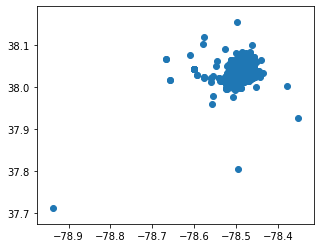

In [8]:
gdf.plot()

In [9]:
gdf.iloc[0]

INCIDENT_ID                                                             2000930
STREET_ADDRESS                                                2400 FONTAINE AVE
IN_ZIP                                                                    22901
LONGITUDE                                                              -78.4948
LATITUDE                                                                38.0699
FIRE_TYPE                     Natural vegetation fire                       ...
INCIDENT_DURATION_MIN                                                     17.35
ALARM_DATE_TIME_AMERICA_NY                                  2002-04-14 12:38:57
year parse                                                                 2002
PROPERTY_LOSS_DOLLARS                                                         0
PROPERTY_USE                                                       Undetermined
FIRE_AREA_OF_ORIGIN                                                         NaN
HEAT_SOURCE                             

In [11]:
def quick_geocode(address: str, city: str = 'Charlottesville, VA, USA'):
    """ Fetch a dict of basic geocoding results based on an address 
        Returned dict will have following keys:
         - 'status_code'  HTTP status code given by geocoding endpoint
         - 'count' count of geocoding results returned
         - 'quality' Numeric quality score of the best geocoding result
         - 'address' Cleaned up address returned for the best geocoding result
         - 'geom' A geometry object representing the best geocoding result
         
    """
    
    geocodes = geocoder.mapbox(f'{quote_plus(address)} {city}')
    rv = dict( 
        status_code = geocodes.status_code,
        count = len(geocodes),
    )
    if len(geocodes):
        best = geocodes.current_result
        rv.update(dict(
            status_code = geocodes.status_code,
            count = len(geocodes),
            quality = best.quality,
            address = best.address,
            geom = shapely.geometry.shape(best.geometry)
        ))
        
    return rv
   

Some addresses contain a `/` which is not correctly URL encoded by the geocoding package.  

In [13]:
gdf[gdf.STREET_ADDRESS.str.contains('\/').fillna(False)].iloc[0]

INCIDENT_ID                                                             2032205
STREET_ADDRESS                                                 315 07 1/2 ST SW
IN_ZIP                                                                    22902
LONGITUDE                                                              -78.4823
LATITUDE                                                                 38.031
FIRE_TYPE                     Mobile property (vehicle) fire                ...
INCIDENT_DURATION_MIN                                                   39.3833
ALARM_DATE_TIME_AMERICA_NY                                  2003-07-29 18:53:09
year parse                                                                 2003
PROPERTY_LOSS_DOLLARS                                                       900
PROPERTY_USE                                             1 or 2 family dwelling
FIRE_AREA_OF_ORIGIN                                        Fuel tank, fuel line
HEAT_SOURCE                             

In [14]:
quick_geocode(
    gdf[gdf.STREET_ADDRESS.str.contains('\/').fillna(False)].iloc[0].STREET_ADDRESS
)

{'status_code': 200,
 'count': 5,
 'quality': 1,
 'address': '315 7 1/2 St SW, Charlottesville, Virginia 22903, United States',
 'geom': <shapely.geometry.point.Point at 0x7fa57d0680d0>}

In [18]:
gcs = []
for i, row in tqdm(gdf.iterrows(), total=len(gdf)):
    if not pandas.isnull(row.STREET_ADDRESS):
        gc = quick_geocode(row.STREET_ADDRESS)
        gc['index'] = i
        gcs.append(gc)

In [20]:
gdf_merged = gdf.merge(
    pandas.DataFrame(gcs),
    how='left', 
    left_index=True, right_index=True,
)

In [21]:
len(gdf), len(gdf_merged)

(1964, 1964)

In [22]:
gdf_merged.columns

Index(['INCIDENT_ID', 'STREET_ADDRESS', 'IN_ZIP', 'LONGITUDE', 'LATITUDE',
       'FIRE_TYPE', 'INCIDENT_DURATION_MIN', 'ALARM_DATE_TIME_AMERICA_NY',
       'year parse', 'PROPERTY_LOSS_DOLLARS', 'PROPERTY_USE',
       'FIRE_AREA_OF_ORIGIN', 'HEAT_SOURCE', 'ITEM_FIRST_IGNITED',
       'CAUSE_OF_IGNITION', 'UNIT_1ST_ARRIVE', 'UNIT_1ST_RESP_TM_MIN',
       'datetime', 'geometry', 'status_code', 'count', 'quality', 'address',
       'geom', 'index'],
      dtype='object')

In [23]:
gdf_merged.quality.describe()

count    1733.000000
mean        0.988379
std         0.056870
min         0.173810
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: quality, dtype: float64

Quick exploration of how far apart the geocoded point and the 

In [27]:
gdf_merged.rename(columns=dict(
    status_code = 'geocode_status_code',
    count = 'geocode_count',
    quality = 'geocode_quality',
    address = 'geocode_address',
    geom = 'geocode_geom',
          ), inplace=True)

In [28]:
gdf_merged.columns

Index(['INCIDENT_ID', 'STREET_ADDRESS', 'IN_ZIP', 'LONGITUDE', 'LATITUDE',
       'FIRE_TYPE', 'INCIDENT_DURATION_MIN', 'ALARM_DATE_TIME_AMERICA_NY',
       'year parse', 'PROPERTY_LOSS_DOLLARS', 'PROPERTY_USE',
       'FIRE_AREA_OF_ORIGIN', 'HEAT_SOURCE', 'ITEM_FIRST_IGNITED',
       'CAUSE_OF_IGNITION', 'UNIT_1ST_ARRIVE', 'UNIT_1ST_RESP_TM_MIN',
       'datetime', 'geometry', 'geocode_status_code', 'geocode_count',
       'geocode_quality', 'geocode_address', 'geocode_geom', 'index'],
      dtype='object')

In [29]:
def reproject_to_utm17n(geom):
    from shapely.ops import transform
    from functools import partial
    import pyproj
    project = partial(
        pyproj.transform,
        pyproj.Proj('urn:ogc:def:crs:OGC:1.3:CRS84'),
        pyproj.Proj('epsg:32617')
    )
    return transform(project, geom)


def point_distances(row):
    """ Given a pandas Series, measure the distance in meters from
        the geometry object in `geometry` to the one in `geocode_geom`.
        This function assumes that the data is all in Central Virginia.
    """
    from numpy import nan
    
    if pandas.isnull(row.geometry):
        return nan
    if pandas.isnull(row.geocode_geom):
        return nan
    # first create a linestring
    ls = shapely.geometry.LineString([row.geometry, row.geocode_geom])
    # convert to EPSG:32617 
    ls_17n = reproject_to_utm17n(ls)
    return ls_17n.length

This is kinda slow..


In [30]:
gdf_merged['point_to_geocode_dist_m'] = gdf_merged.apply(point_distances, axis=1)

In [34]:
gdf_merged.point_to_geocode_dist_m.describe()

count    1733.000000
mean             inf
std              NaN
min         8.724432
25%      1633.569621
50%      2592.232749
75%      3883.777957
max              inf
Name: point_to_geocode_dist_m, dtype: float64

In [45]:
gdf_merged[gdf_merged.point_to_geocode_dist_m != numpy.inf].point_to_geocode_dist_m.describe()

count    1.712000e+03
mean     5.989081e+03
std      5.586220e+04
min      8.724432e+00
25%      1.625480e+03
50%      2.565050e+03
75%      3.840599e+03
max      1.810351e+06
Name: point_to_geocode_dist_m, dtype: float64

That is not a very hopeful result there. The median is ~ 2.5km away. 

May be some more we can do to get better result out of our geocode query.

In [33]:
gdf_merged[gdf_merged.point_to_geocode_dist_m > 50000]

,INCIDENT_ID,STREET_ADDRESS,IN_ZIP,LONGITUDE,LATITUDE,FIRE_TYPE,INCIDENT_DURATION_MIN,ALARM_DATE_TIME_AMERICA_NY,year parse,PROPERTY_LOSS_DOLLARS,...,UNIT_1ST_RESP_TM_MIN,datetime,geometry,geocode_status_code,geocode_count,geocode_quality,geocode_address,geocode_geom,index,point_to_geocode_dist_m
24,2030519,1800 JEFFERSON PARK AVE,22901,NaN,NaN,Structure Fire ...,206.316667,2003-02-21 19:34:44,2003,30000.0,...,4.266667,2003-02-21 19:34:44,POINT (nan nan),200.0,5.0,1.000000,"319 East Main Street, Charlottesville, Virgini...",POINT (-78.479405 38.030421),29.0,inf
76,2032052,617 9TH STREET SW,22902,NaN,NaN,Structure Fire ...,87.550000,2003-07-13 16:50:57,2003,0.0,...,3.933333,2003-07-13 16:50:57,POINT (nan nan),200.0,5.0,1.000000,"402 Monticello Road, Charlottesville, Virginia...",POINT (-78.47609 38.025223),97.0,inf
101,2033522,1900 JEFFERSON PARK,22901,NaN,NaN,Structure Fire ...,59.850000,2003-11-04 19:26:09,2003,0.0,...,0.133333,2003-11-04 19:26:09,POINT (nan nan),200.0,5.0,1.000000,"1215 Lee Street, Charlottesville, Virginia 229...",POINT (-78.49934500000001 38.031439),125.0,inf
139,2040235,353 10TH ST NW,22902,-78.492471,38.036994,Structure Fire ...,97.300000,2004-01-25 14:36:19,2004,7000.0,...,2.633333,2004-01-25 14:36:19,POINT (-78.492 38.037),200.0,3.0,0.507500,"14 9th Street, West Palm Beach, Florida 33401,...",POINT (-80.056836 26.721592),169.0,1.263266e+06
266,3040070,7 W PAVILION - BLDG,22904,NaN,NaN,Structure Fire ...,92.816667,2004-02-01 14:53:13,2004,2000.0,...,2.350000,2004-02-01 14:53:13,POINT (nan nan),200.0,5.0,1.000000,"132 Chancellor Street, Charlottesville, Virgin...",POINT (-78.50055500000001 38.037077),327.0,inf
277,2050146,243 RIDGE MCINTIRE RD,22903,NaN,NaN,Mobile property (vehicle) fire ...,32.666667,2005-01-13 11:53:40,2005,0.0,...,0.750000,2005-01-13 11:53:40,POINT (nan nan),200.0,5.0,1.000000,"207 14th Street Northwest, Charlottesville, Vi...",POINT (-78.49931100000001 38.035307),341.0,inf
314,2051621,102 KEYSTONE PL,22901,NaN,NaN,Natural vegetation fire ...,23.083333,2005-04-20 18:38:26,2005,0.0,...,3.300000,2005-04-20 18:38:26,POINT (nan nan),200.0,5.0,1.000000,"1404 Meadowbrook Road, Charlottesville, Virgin...",POINT (-78.495903 38.054123),390.0,inf
378,2504495,NaN,22901,-78.490470,38.009550,Natural vegetation fire ...,10.100000,2005-10-04 15:02:31,2005,NaN,...,3.033333,2005-10-04 15:02:31,POINT (-78.490 38.010),200.0,5.0,0.754286,"500 East Jefferson Street, Falls Church, Virgi...",POINT (-77.160886 38.882798),460.0,1.513041e+05
443,2600814,1370 MONACAN TRAIL RD,22922,-78.937220,37.710800,Natural vegetation fire ...,12.450000,2006-02-20 15:26:11,2006,NaN,...,8.050000,2006-02-20 15:26:11,POINT (-78.937 37.711),200.0,5.0,0.948000,"1705 Emmet Street North, Charlottesville, Virg...",POINT (-78.49449199999999 38.059243),543.0,5.489242e+04
496,2601940,2005 ABBEY RD,22903,-78.445876,38.030575,Natural vegetation fire ...,34.333333,2006-04-27 15:02:04,2006,NaN,...,5.250000,2006-04-27 15:02:04,POINT (-78.446 38.031),200.0,5.0,0.754286,"202 15th Street Southwest, Roanoke, Virginia 2...",POINT (-79.965748 37.274485),600.0,1.581961e+05


We see that we have some issues where the original coordinates are NaN. 

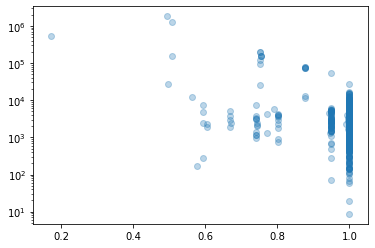

In [44]:
plt.scatter(
    gdf_merged[gdf_merged.point_to_geocode_dist_m != numpy.inf].geocode_quality,
    gdf_merged[gdf_merged.point_to_geocode_dist_m != numpy.inf].point_to_geocode_dist_m,
    alpha=0.3
)
plt.yscale('log')